In [40]:
import os
import glob
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt
from pprint import pprint
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, merge
from keras.models import Model
from keras.layers import Convolution2D, MaxPooling2D, Reshape, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
data_dir = "src/client/pictures/"
data_save_dir = "datasets/npy/"
big_dir = "tawn_dataset/"

def normalize_label(old_val, old_min, old_max, new_min, new_max):
    old_val = float(old_val)
    new_val = (((old_val - old_min) * (new_max - new_min)) / (old_max - old_min)) + new_min
    return new_val

In [25]:
image_paths = []
angle_labels = []
speed_labels = []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith(".jpg"):
            filename = os.path.join(root, file)
            image_paths.append(filename)
            s = filename.split("_")
            print("angle:",s[1])
            print("speed:",s[2].rstrip(s[2][-4:]))
            angle_labels.append(float(s[1]))
            speed_labels.append(float(s[2].rstrip(s[2][-4:])))
image_paths = np.array(image_paths)
angle_labels = np.array(angle_labels)
speed_labels = np.array(speed_labels)

angle: 125
speed: 102
angle: 35
speed: 77
angle: 125
speed: 102
angle: 125
speed: 102
angle: 125
speed: 102
angle: 205
speed: 77
angle: 125
speed: 102
angle: 125
speed: 41
angle: 151
speed: 84
angle: 125
speed: 102
angle: 125
speed: 69
angle: 125
speed: 102
angle: 38
speed: 64
angle: 35
speed: 102
angle: 125
speed: 27
angle: 125
speed: 97
angle: 125
speed: 27
angle: 171
speed: 34
angle: 116
speed: 102
angle: 125
speed: 27
angle: 184
speed: 71
angle: 125
speed: 27
angle: 55
speed: 102
angle: 199
speed: 77
angle: 125
speed: 102
angle: 125
speed: 102
angle: 125
speed: 102
angle: 141
speed: 79
angle: 55
speed: 69
angle: 125
speed: 102
angle: 51
speed: 83
angle: 192
speed: 88
angle: 125
speed: 102
angle: 205
speed: 85
angle: 42
speed: 83
angle: 116
speed: 102
angle: 125
speed: 102
angle: 125
speed: 102
angle: 38
speed: 86
angle: 125
speed: 102
angle: 43
speed: 83
angle: 192
speed: 61
angle: 192
speed: 67
angle: 125
speed: 102
angle: 35
speed: 102
angle: 57
speed: 64
angle: 125
speed: 27
ang

In [26]:
(angle_labels.shape, speed_labels.shape, image_paths.shape)

((185,), (185,), (185,))

In [41]:
data = np.zeros((image_paths.shape[0], 120, 160, 3))
for i in range(image_paths.shape[0]):
    img = cv2.imread(image_paths[i])
    y1 = int(img.shape[0] / 2)
    img = img[y1:, :]
    img = cv2.resize(img, (160, 120), interpolation = cv2.INTER_CUBIC)
    data[i] = img

In [28]:
data.shape

(185, 120, 160, 3)

In [44]:
angle_labels = ((angle_labels - 35) / 170.0 - 0.5) * 2
idx = 0
for spd in speed_labels:
    speed_labels[idx] = normalize_label(spd, 27, 102, 0, 1)
    idx += 1

In [45]:
print(str(speed_labels))

[ 1.          0.66666667  1.          1.          1.          0.66666667
  1.          0.18666667  0.76        1.          0.56        1.
  0.49333333  1.          0.          0.93333333  0.          0.09333333
  1.          0.          0.58666667  0.          1.          0.66666667
  1.          1.          1.          0.69333333  0.56        1.
  0.74666667  0.81333333  1.          0.77333333  0.74666667  1.          1.
  1.          0.78666667  1.          0.74666667  0.45333333  0.53333333
  1.          1.          0.49333333  0.          1.          1.          0.76
  0.42666667  1.          0.          1.          1.          0.69333333
  1.          1.          1.          1.          1.          0.48        0.76
  0.          1.          0.          0.          0.          1.          0.6
  0.          0.76        0.62666667  1.          1.          0.45333333
  1.          1.          0.49333333  1.          0.42666667  1.          1.
  1.          0.54666667  0.74666667  0.76

In [34]:
print(str(angle_labels))

[ 0.05882353 -1.          0.05882353  0.05882353  0.05882353  1.
  0.05882353  0.05882353  0.36470588  0.05882353  0.05882353  0.05882353
 -0.96470588 -1.          0.05882353  0.05882353  0.05882353  0.6
 -0.04705882  0.05882353  0.75294118  0.05882353 -0.76470588  0.92941176
  0.05882353  0.05882353  0.05882353  0.24705882 -0.76470588  0.05882353
 -0.81176471  0.84705882  0.05882353  1.         -0.91764706 -0.04705882
  0.05882353  0.05882353 -0.96470588  0.05882353 -0.90588235  0.84705882
  0.84705882  0.05882353 -1.         -0.74117647  0.05882353 -0.50588235
  0.05882353 -0.42352941  0.84705882  0.05882353  0.05882353 -1.
  0.05882353  0.87058824  0.05882353  0.05882353  0.05882353  0.05882353
 -1.          0.84705882  0.90588235  0.05882353  0.82352941  0.05882353
  0.05882353  0.05882353  0.05882353 -0.04705882  0.05882353  0.87058824
 -0.77647059  0.05882353  0.05882353  0.75294118  0.05882353  0.05882353
 -0.82352941 -0.63529412 -0.97647059  0.05882353  0.05882353  0.05882353
 

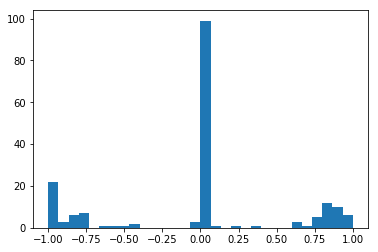

In [36]:
plt.hist(angle_labels, bins=30)
plt.show()

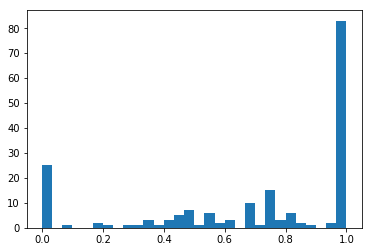

In [46]:
plt.hist(speed_labels, bins=30)
plt.show()

In [47]:
def AnglePredCnn():
    img_in = Input(shape=(120, 160, 3), name='img_in')                      # First layer, input layer, Shape comes from camera.py resolution, RGB
    x = img_in
    x = Convolution2D(24, (5,5), strides=(2,2), activation='relu')(x)       # 24 features, 5 pixel x 5 pixel kernel (convolution, feauture) window, 2wx2h stride, relu activation
    x = Convolution2D(32, (5,5), strides=(2,2), activation='relu')(x)       # 32 features, 5px5p kernel window, 2wx2h stride, relu activatiion
    x = Convolution2D(64, (5,5), strides=(2,2), activation='relu')(x)       # 64 features, 5px5p kernal window, 2wx2h stride, relu
    x = Convolution2D(64, (3,3), strides=(2,2), activation='relu')(x)       # 64 features, 3px3p kernal window, 2wx2h stride, relu
    x = Convolution2D(64, (3,3), strides=(1,1), activation='relu')(x)       # 64 features, 3px3p kernal window, 1wx1h stride, relu

    # Possibly add MaxPooling (will make it less sensitive to position in image).  Camera angle fixed, so may not to be needed

    x = Flatten(name='flattened')(x)                                        # Flatten to 1D (Fully connected)
    x = Dense(100, activation='linear')(x)                                    # Classify the data into 100 features, make all negatives 0
    x = Dropout(.1)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
    x = Dense(50, activation='linear')(x)                                     # Classify the data into 50 features, make all negatives 0
    x = Dropout(.1)(x)                                                      # Randomly drop out 10% of the neurons (Prevent overfitting)
    #categorical output of the angle
    angle_out = Dense(1, activation='linear', name='angle_out')(x)        # Connect every input with every output and output 15 hidden units. Use Softmax to give percentage. 15 categories and find best one based off percentage 0.0-1.0
    
    #continous output of throttle
    throttle_out = Dense(1, activation='linear', name='throttle_out')(x)      # Reduce to 1 number, Positive number only
    
    model = Model(inputs=[img_in], outputs=[angle_out, throttle_out])
    model.compile(optimizer='adam',
                  loss={'angle_out': 'mean_squared_error',
                        'throttle_out': 'mean_squared_error'},
                  loss_weights={'angle_out': 0.9, 'throttle_out': .001})
    return model

In [48]:
model = AnglePredCnn()

In [49]:
hist = model.fit(data, [angle_labels, speed_labels], validation_split=0.1, epochs=6, batch_size=16)

Train on 166 samples, validate on 19 samples
Epoch 1/6
166/166 [==============================] - 4s 25ms/step - loss: 9.9924 - angle_out_loss: 11.0976 - throttle_out_loss: 4.5819 - val_loss: 0.1539 - val_angle_out_loss: 0.1705 - val_throttle_out_loss: 0.3952
Epoch 2/6
166/166 [==============================] - 1s 3ms/step - loss: 0.3554 - angle_out_loss: 0.3942 - throttle_out_loss: 0.5920 - val_loss: 0.2181 - val_angle_out_loss: 0.2417 - val_throttle_out_loss: 0.6257
Epoch 3/6
166/166 [==============================] - 1s 3ms/step - loss: 0.1447 - angle_out_loss: 0.1599 - throttle_out_loss: 0.7044 - val_loss: 0.0707 - val_angle_out_loss: 0.0777 - val_throttle_out_loss: 0.7915
Epoch 4/6
166/166 [==============================] - 1s 3ms/step - loss: 0.0942 - angle_out_loss: 0.1042 - throttle_out_loss: 0.4799 - val_loss: 0.0663 - val_angle_out_loss: 0.0733 - val_throttle_out_loss: 0.2785
Epoch 5/6
166/166 [==============================] - 1s 3ms/step - loss: 0.0715 - angle_out_loss: 0.0

In [19]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_in (InputLayer)             (None, 120, 160, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 58, 78, 24)   1824        img_in[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 27, 37, 32)   19232       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 12, 17, 64)   51264       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

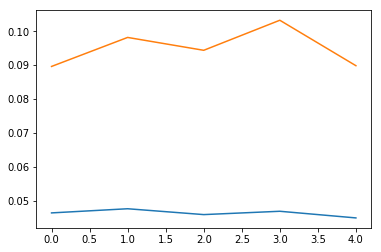

In [15]:
plt.plot(hist.history["loss"][1:])
plt.plot(hist.history["val_loss"][1:])
plt.show()

In [16]:
model.save("models/new_cam.h5")

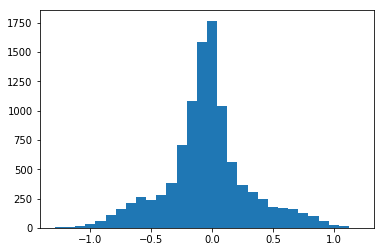

In [17]:
plt.hist(model.predict(data)[0], bins=30)
plt.show()

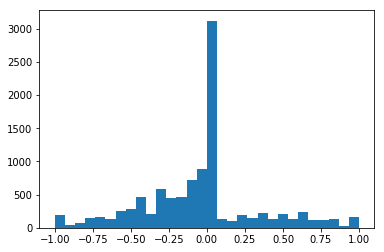

In [18]:
plt.hist(labels, bins=30)
plt.show()

In [45]:
data.shape

(1381, 120, 160, 3)

In [46]:
labels.shape

(1381,)

In [106]:
mask = np.where((labels > -0.08) & (labels < 0.08))
mask = (np.random.choice(mask[0], int(2 * mask[0].shape[0] / 3), replace=False),)

maska = np.ones(labels.shape,dtype=bool)
maska[mask] = False

In [107]:
labels[maska].shape

(936,)

In [108]:
labels = labels[maska]
data = data[maska]

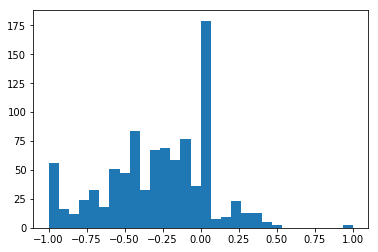

In [109]:
plt.hist(labels, bins=30)
plt.show()

In [182]:
from random import shuffle

def build_dataset(datas):
    dataset = np.zeros((len(datas), 120, 160, 3))
    for i in range(len(datas)):    
        img = cv2.imread(datas[i])
        img = img[y1:, :]
        img = cv2.resize(img, (160, 120), interpolation = cv2.INTER_CUBIC)
        dataset[i,:,:,:] = img
        return dataset

def build_labels(datas):
    labels = np.array([data[1] for data in datas])
    return to_categorical(labels, 15)


def myGenerator(datas, labels, batch=16):
    # For each epoch
    while 1:
        # Suffle datas
        indexes = list(range(len(datas)))
        shuffle(indexes)
        
        # For each batch
        for i in range(0, len(datas), batch):
            
            # Build a batch of datas
            batch_data = [datas[indexes[j]] for j in range(i, i + batch) if j < len(datas)]
            y = [labels[indexes[j]] for j in range(i, i + batch) if j < len(labels)]
            
            y = np.array(y)
            # Build the dataset for the batch
            x = build_dataset(batch_data)
            
            yield x, y

In [183]:
test = myGenerator(image_paths, labels, 16)
for j in range(0, 4):
    x, y = next(test)
    print(x.shape)
    print(y.shape)

(16, 120, 160, 3)
(16,)
(16, 120, 160, 3)
(16,)
(16, 120, 160, 3)
(16,)
(16, 120, 160, 3)
(16,)
